# SQL Проект: Аналитика платформы IT Resume.

# Цели исследования:

* Проанализировать базу данных и рассчитать ключевые продуктовые метрики для данной платформы.
* Построить наглядные графики по полученным данным и подвести итоги анализа.

**Таблица `transaction`**

Содержит данные о транзакциях:

`id` — идентификатор транзакции;

`created_at` — дата транзакции;

`value` — стоимость транзакции;

`type_id` — тип транзакции.

`user_id` — индетификатор пользователя.


**Таблица `users`**

Содержит данные о пользователях:

`id` — индетификатор пользователя;

`username`, `first_name`, `last_name` — никнейм, имя и фамилия пользователя;

`is_active` — bool-значение активности пользователя;

`date_joined` — дата регистрации пользователя;

`email` — email пользователя;

`company_id` — индетификатор компании, где пользователь числится студентом.


**Таблица `userentry`**

Содержит данные о заходах пользователей на платформу:

`id` — индетификатор захода;

`entry_at` — дата захода на платформу;

`page_id` — индетификатор страницы;

`user_id` — индетификатор пользователя.


**Таблицы `codesubmit`, `coderun`, `teststart`**

Содержат данные о попытках решения тестов и задач


**Таблица `TransactionType`**
(вспомогательная таблица, в запросах её не будет, но данные о типе транзакций взяты с неё)

# Содержание:
<a id='content'></a>
[1 Шаг. Импорт библиотек](#part_1)

[2 Шаг. Изучение общей информации](#part_2)

[3 Шаг. Задачи исследования](#part_3)

[3.1  Узнаем кол-во купленных подсказок и решений, а также в среднем на 1 пользователя;](#part_3.1)

[3.2  Рассчитываем распределение баланса пользователей на платформе;](#part_3.2)

[3.3  Рассчитываем DAU/WAU/MAU и в целом распределение активности пользователей;](#part_3.3)

[3.4  Рассчитываем Retention;](#part_3.4)

[Вывод](#part_4)

## 1 Шаг. Импорт библиотек 
<a id='part_1'></a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

In [2]:
db_config = {'user': 'student',
             'pwd': 'qweasd963', 
             'host': '89.208.197.76', 'port': 5432,
             'db': 'simulative'} 
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(db_config['user'],  db_config['pwd'],  
                                                         db_config['host'],  db_config['port'],  
                                                         db_config['db'])

In [3]:
engine = create_engine(connection_string) 

##  2 Шаг. Изучение общей информации 
<a id='part_2'></a>

In [4]:
transaction = '''SELECT * FROM transaction LIMIT 5'''
pd.io.sql.read_sql(transaction, con = engine)

,id,created_at,value,type_id,user_id
0,1,2021-06-23 10:55:44.535735,100,1,2
1,2,2021-06-23 10:57:32.260228,100,1,2
2,3,2021-06-23 11:00:31.750230,100,1,2
3,4,2021-06-23 11:28:14.502607,1500,2,2
4,5,2021-06-23 14:28:50.171772,100,1,2


In [5]:
users = '''SELECT * FROM users LIMIT 5'''
pd.io.sql.read_sql(users, con = engine)

,id,username,first_name,last_name,is_active,date_joined,email,referal_user,company_id,tier,score
0,198,Pbnnd,None,None,1,2021-11-23 13:58:52.051036,jbsnjbf@gmail.com,None,NaN,1,0
1,52,fjbis,Элина,Полякова,1,2021-09-01 12:04:31.148715,fjbis@yandex.ru,None,NaN,1,0
2,331,jjxbfox,Эмилия,Афанасьев,1,2021-12-12 07:03:00.583264,jjxbfox@bk.ru,None,NaN,1,0
3,416,nsosabisfsobm,None,None,1,2022-01-02 12:22:43.014039,isfsobm.nseo@gmail.com,None,1.0,1,0
4,19,Fofbx196,Эмилия,Фролова,1,2021-04-22 15:37:33.000000,koonbnanojj.jofbx@yandex.ru,None,NaN,1,0


In [6]:
userentry = '''SELECT * FROM userentry LIMIT 5'''
pd.io.sql.read_sql(userentry, con = engine)

,id,entry_at,page_id,user_id
0,1,2021-04-13 08:31:45,4,1
1,2,2021-04-11 16:04:20,5,8
2,3,2021-04-24 07:29:36,9,4
3,4,2021-04-26 20:36:03,2,13
4,5,2021-04-27 16:20:12,5,14


In [7]:
#Возьмём для примера только таблицу teststart из трёх названных, т.к. структура у всех в целом одинаковая
teststart = '''SELECT * FROM teststart LIMIT 5'''
pd.io.sql.read_sql(teststart, con = engine)

,id,created_at,test_id,user_id
0,1,2021-05-11 02:10:30,2,2
1,2,2021-04-26 17:11:56,11,5
2,3,2021-04-29 23:50:31,1,25
3,4,2021-04-30 18:03:49,5,17
4,5,2021-05-15 15:41:10,11,1


Получили наглядное представление о том, какие данные содержатся в таблицах

## 3 Шаг. Задачи исследования
<a id='part_3'></a>

### 3.1 Узнаем кол-во купленных подсказок и решений, а также в среднем на 1 пользователя;
<a id='part_3.1'></a>
Начнём с достаточно простой задачи и постепенно будем увеличивать обороты

<b> Важная пометка! </b>                                          
<b> Во всех расчётах исключаем пользователей с id<94 - это внутренние аккаунты компании, a также исключаем все транзакции больше 500 монет - это начисления бета тестерам и они могут очень </b> <b>сильно исказить статистику </b>

In [8]:
#транзакции с type_id = 24 - покупка подсказок, 25 - покупка решений
bought_sol_hint = '''
WITH podskazka as(
    SELECT user_id, 
           COUNT(type_id) as cnt_podskazka 
    FROM "transaction"
    WHERE value <=500 
    AND user_id > 94 
    AND type_id = 24 
    GROUP BY 1),
reshenie as(
    SELECT user_id, 
           COUNT(type_id) as cnt_reshenie 
    FROM "transaction"
    WHERE value <=500 
    AND user_id > 94 
    AND type_id = 25
    GROUP BY 1)
SELECT ROUND(AVG(cnt_podskazka), 2) as avg_podskazok, 
       SUM(cnt_podskazka) as sum_podskazok,
       ROUND(AVG(cnt_reshenie), 2) as avg_resheniy, 
       SUM(cnt_reshenie) as sum_resheniy 
FROM podskazka p
FULL JOIN reshenie r ON r.user_id = p.user_id
'''
pd.io.sql.read_sql(bought_sol_hint, con = engine)

,avg_podskazok,sum_podskazok,avg_resheniy,sum_resheniy
0,2.16,106.0,2.58,377.0


### 3.2 Рассчитываем распределение баланса пользователей на платформе;
<a id='part_3.2'></a>

Для начала просто посмотрим на распределение баланса с перцентилем 0.1, для получения точных цифр

In [9]:
#транзакции с type_id = 23-27 связанны с тратой денег, а 2-22 с получением
balance = '''
WITH balance as(
    SELECT user_id, 
           SUM(value)*-1 as value 
    FROM "transaction" 
    WHERE value <=500 
    AND user_id > 94 
    AND type_id BETWEEN 23 AND 27
    GROUP BY 1
    UNION
    SELECT user_id, 
           SUM(value) as value 
    FROM "transaction"
    WHERE value <=500 
    AND user_id > 94 
    AND type_id BETWEEN 2 AND 22
    GROUP BY 1),
prep as(
    SELECT user_id, 
           SUM(value) as balance 
    FROM balance 
    GROUP BY 1 
    HAVING SUM(value)>0)
SELECT percentile_disc(0) WITHIN GROUP (ORDER BY balance) as "0.0", 
       percentile_disc(0.1) WITHIN GROUP (ORDER BY balance) as "0.1",
       percentile_disc(0.2) WITHIN GROUP (ORDER BY balance) as "0.2",
       percentile_disc(0.3) WITHIN GROUP (ORDER BY balance) as "0.3",
       percentile_disc(0.4) WITHIN GROUP (ORDER BY balance) as "0.4",
       percentile_disc(0.5) WITHIN GROUP (ORDER BY balance) as "0.5",
       percentile_disc(0.6) WITHIN GROUP (ORDER BY balance) as "0.6",
       percentile_disc(0.7) WITHIN GROUP (ORDER BY balance) as "0.7",
       percentile_disc(0.8) WITHIN GROUP (ORDER BY balance) as "0.8",
       percentile_disc(0.9) WITHIN GROUP (ORDER BY balance) as "0.9",
       percentile_disc(1) WITHIN GROUP (ORDER BY balance) as "1.0"
FROM prep
'''
pd.io.sql.read_sql(balance, con = engine)

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
0,1.0,26.0,53.0,53.0,53.0,61.0,77.0,93.0,103.0,131.0,2216.0


А теперь создадим более наглядный график

In [10]:
balance = '''
WITH balance as(
    SELECT user_id, 
           SUM(value)*-1 as value 
    FROM "transaction" 
    WHERE value <=500 
    AND user_id > 94 
    AND type_id BETWEEN 23 AND 27
    GROUP BY 1
    UNION
    SELECT user_id, 
           SUM(value) as value 
    FROM "transaction"
    WHERE value <=500 
    AND user_id > 94 
    AND type_id BETWEEN 2 AND 22
    GROUP BY 1),
prep as(
    SELECT user_id, 
           SUM(value) as balance 
    FROM balance 
    GROUP BY 1 
    HAVING SUM(value)>0)
SELECT * FROM prep
'''
bal = pd.io.sql.read_sql(balance, con = engine)
bal.head(5)

,user_id,balance
0,1798,108.0
1,2335,117.0
2,1269,53.0
3,273,189.0
4,1560,53.0


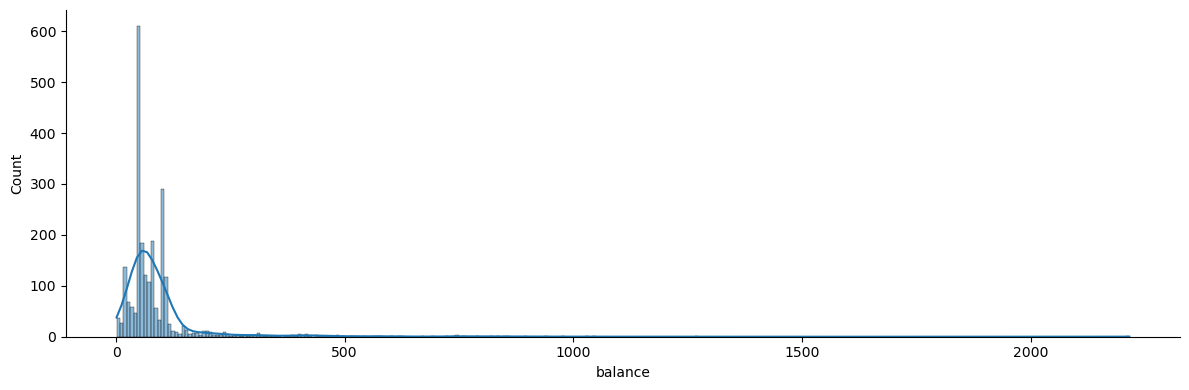

In [11]:
sns.displot(data=bal, x="balance", kde="true", 
            height=4, aspect=3)
plt.show()

А теперь отрежем хвост у нашего графика, для получения более точной картины распределения в доминирующей массе пользователей

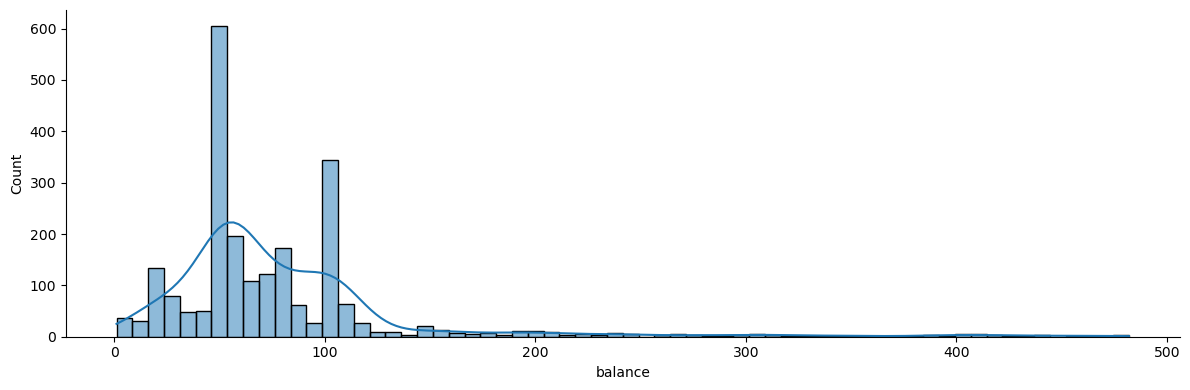

In [12]:
sns.displot(data=bal[bal["balance"] < 500], x="balance", kde="true", 
            height=4, aspect=3)
plt.show()

### 3.3 Рассчитываем DAU/WAU/MAU и в целом распределение активности пользователей;
<a id='part_3.3'></a>

`DAU/WAU/MAU` - метрики, показывающие сколько пользователей использовали ваш продукт в заданный период
* daily active users
* weekly active users
* monthly active users

In [13]:
DAU = '''
SELECT TO_CHAR(entry_at, 'YY-MM-dd') as day,
       COUNT(DISTINCT user_id) as DAU
FROM userentry
WHERE user_id > 94
GROUP BY day
ORDER BY day
'''
dau_check = pd.io.sql.read_sql(DAU, con = engine)
dau_check.head(5)

,day,dau
0,21-11-20,30
1,21-11-21,23
2,21-11-22,20
3,21-11-23,60
4,21-11-24,42


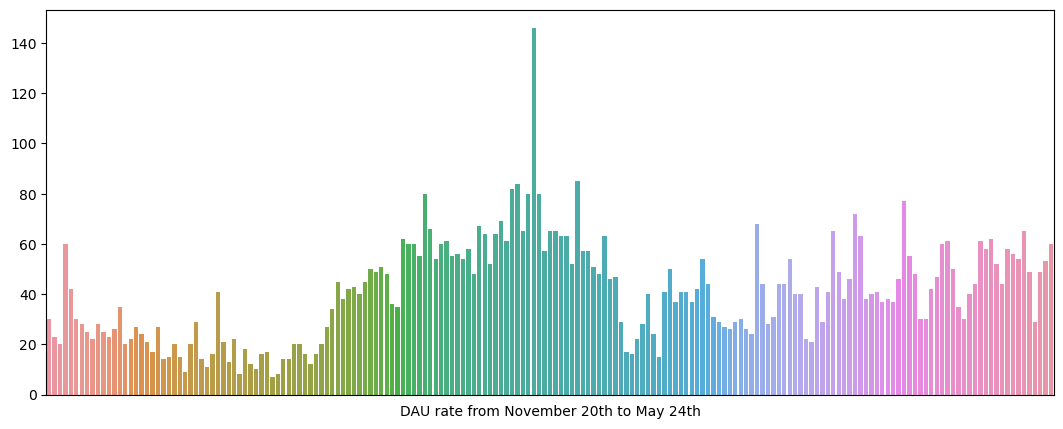

In [14]:
f, ax = plt.subplots(figsize=(13, 5))
sns.barplot(data=dau_check, x="day", y="dau")
plt.xticks([])
ax.set(ylabel="",
       xlabel="DAU rate from November 20th to May 24th")
plt.show()

In [15]:
WAU = '''
SELECT TO_CHAR(entry_at, 'YY-WW') as week,
       COUNT(DISTINCT user_id) as WAU
FROM userentry
WHERE user_id > 94
GROUP BY week
ORDER BY week
'''
wau_check = pd.io.sql.read_sql(WAU, con = engine)
wau_check.head(5)

,week,wau
0,21-47,133
1,21-48,93
2,21-49,85
3,21-50,73
4,21-51,89


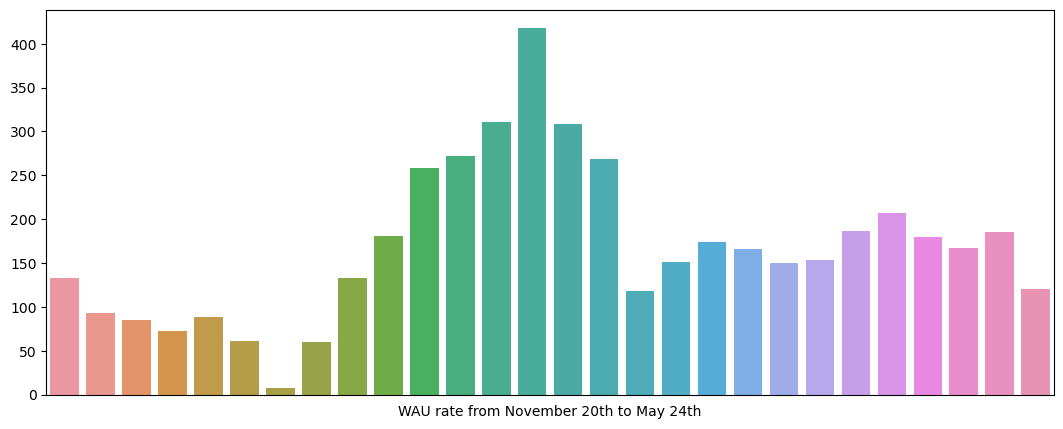

In [16]:
f, ax = plt.subplots(figsize=(13, 5))
sns.barplot(data=wau_check, x="week", y="wau")
plt.xticks([])
ax.set(ylabel="",
       xlabel="WAU rate from November 20th to May 24th")
plt.show()

In [17]:
MAU = '''
SELECT TO_CHAR(entry_at, 'YY-MM') as month,
       TO_CHAR(entry_at, 'Mon YYYY') as month_for_people,
       COUNT(DISTINCT user_id) as MAU
FROM userentry
WHERE user_id > 94
GROUP BY 1, 2
ORDER BY month
'''
mau_check = pd.io.sql.read_sql(MAU, con = engine)
mau_check

,month,month_for_people,mau
0,21-11,Nov 2021,174
1,21-12,Dec 2021,195
2,22-01,Jan 2022,579
3,22-02,Feb 2022,1057
4,22-03,Mar 2022,570
5,22-04,Apr 2022,530
6,22-05,May 2022,432


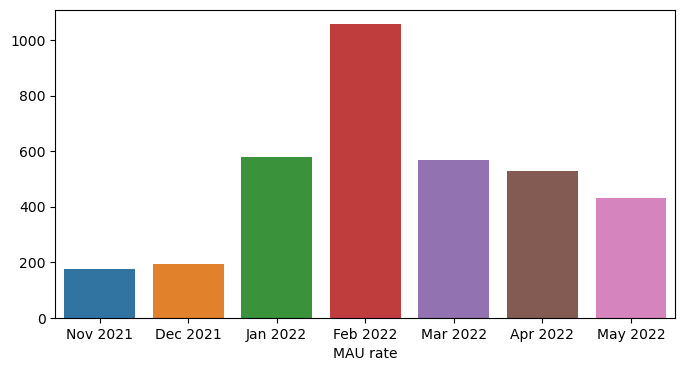

In [18]:
f, ax = plt.subplots(figsize=(8, 4))
sns.barplot(data=mau_check, x="month_for_people", y="mau")
ax.set(ylabel="",
       xlabel="MAU rate")
plt.show()

Можно явно заметить тенденцию стремительного роста, начиная с начала января и вплоть до конца февраля, что, скорее всего, обусловлено желанием людей заниматься саморазвитием в новом году. И после такого многократного роста, как следствие, можно увидеть коррекцию и снижение активности, ведь остались только люди, которые действительно замотивированны на саморазвитие

In [19]:
#Распределение активности по дням недели
Week_Activity = '''
WITH activity as(
    SELECT created_at, user_id FROM codesubmit
    UNION ALL
    SELECT created_at, user_id FROM coderun
    UNION ALL
    SELECT created_at, user_id FROM teststart)
SELECT TO_CHAR(created_at, 'ID Dy') as day,
       COUNT(user_id) as activ
FROM activity
GROUP BY 1
'''
wa = pd.io.sql.read_sql(Week_Activity, con = engine)
wa

,day,activ
0,1 Mon,11854
1,2 Tue,11719
2,3 Wed,13593
3,4 Thu,13767
4,5 Fri,12272
5,6 Sat,9392
6,7 Sun,9475


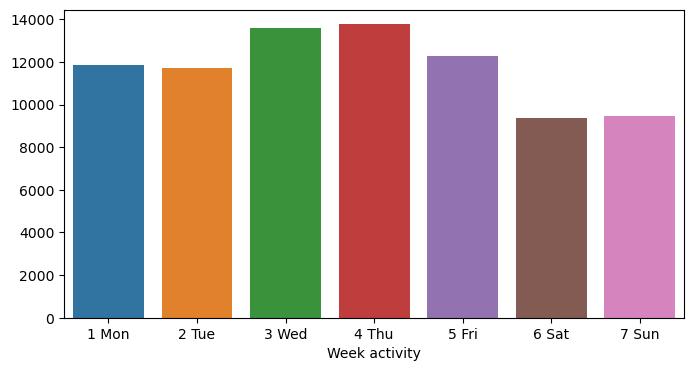

In [20]:
f, ax = plt.subplots(figsize=(8, 4))
sns.barplot(data=wa, x="day", y="activ")
ax.set(ylabel="",
       xlabel="Week activity")
plt.show()

Ничего особо интересного, людям свойственно отдыхать в выходные, и как итог мы можем наблюдать плавное понижение активности, начиная с пятницы

In [21]:
#Распределение активности по времени суток
Hours_Activity = '''
WITH activity as(
    SELECT created_at, user_id FROM codesubmit
    UNION ALL
    SELECT created_at, user_id FROM coderun
    UNION ALL
    SELECT created_at, user_id FROM teststart)
SELECT TO_CHAR(created_at, 'HH24') as hour,
       COUNT(user_id) as activ
FROM activity
GROUP BY 1
'''
ha = pd.io.sql.read_sql(Hours_Activity, con = engine)
ha.head(5)

,hour,activ
0,00,597
1,01,351
2,02,288
3,03,482
4,04,908


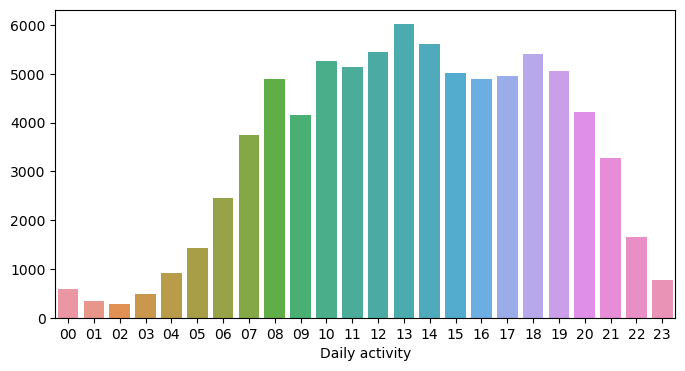

In [22]:
f, ax = plt.subplots(figsize=(8, 4))
sns.barplot(data=ha, x="hour", y="activ")
ax.set(ylabel="",
       xlabel="Daily activity")
plt.show()

Активность пользователей бурно нарастает с 2 утра, достигая своего пика в час дня, а затем плавно понижается после 6 вечера. Также исходя из графика можно сделать вывод, что наибольшее число людей предпочитают заниматься решением задачек с 10 утра до 7 вечера 

А теперь интереса ради посмотрим какой % заходов на платформа не сопровождается активностью

In [23]:
Activity_Check = '''
WITH activity as(
    SELECT created_at, user_id FROM codesubmit
    UNION ALL
    SELECT created_at, user_id FROM coderun
    UNION ALL
    SELECT created_at, user_id FROM teststart), 
prep as(
    SELECT ue.user_id, 
           CASE WHEN ac.user_id IS NULL THEN 1 ELSE 0 END is_not_active 
    FROM userentry ue
    LEFT JOIN activity ac 
    ON TO_CHAR(ue.entry_at, 'YY-MM-DD HH24-MI') = TO_CHAR(ac.created_at, 'YY-MM-DD HH24-MI')
    AND ac.user_id = ue.user_id 
    JOIN users us ON ue.user_id = us.id)
SELECT ROUND(SUM(is_not_active)/COUNT(is_not_active)::numeric*100, 2) as procent 
FROM prep
'''
pd.io.sql.read_sql(Activity_Check, con = engine)

,procent
0,68.44


### 3.4 Рассчитываем Retention;
<a id='part_3.4'></a>

`N-Day Retention` - это метрика, которая показывает, какой процент пользователей вернулся в продукт спустя N дней после установки приложения/первого посещения.

In [24]:
NDay_Retention = '''
WITH prep as(
    SELECT TO_CHAR(u2.date_joined, 'MM') as month, 
           EXTRACT(days FROM u.entry_at-u2.date_joined) as diff,
           COUNT(DISTINCT user_id) as total 
    FROM userentry u
    JOIN users u2 ON u2.id = u.user_id
    WHERE TO_CHAR(u2.date_joined, 'YYYY') = '2022'
    AND extract(days from u.entry_at - u2.date_joined) IN (0, 1, 3, 7, 14, 30)
    GROUP BY month, diff)
SELECT TO_CHAR(TO_DATE(month, 'MM'), 'Month') as month,
       MAX(CASE WHEN diff = 0 THEN total END) as "0",
       MAX(CASE WHEN diff = 1 THEN total END) as "1",
       MAX(CASE WHEN diff = 3 THEN total END) as "3",
       MAX(CASE WHEN diff = 7 THEN total END) as "7",
       MAX(CASE WHEN diff = 14 THEN total END) as "14",
       MAX(CASE WHEN diff = 30 THEN total END) as "30"
FROM prep
GROUP BY month
'''
pd.io.sql.read_sql(NDay_Retention, con = engine)

,month,0,1,3,7,14,30
0,January,481,84,45,27,24,6
1,February,883,94,41,22,12,5
2,March,411,44,32,12,7,4
3,April,203,33,30,15,12,5


А теперь посчитаем в процентном соотношении

In [25]:
NDay_Retention_percent = '''
WITH prep as(
    SELECT TO_CHAR(u2.date_joined, 'MM') as month, 
           EXTRACT(days FROM u.entry_at-u2.date_joined) as diff,
           COUNT(DISTINCT user_id) as total 
    FROM userentry u
    JOIN users u2 ON u2.id = u.user_id
    WHERE TO_CHAR(u2.date_joined, 'YYYY') = '2022'
    AND extract(days from u.entry_at - u2.date_joined) IN (0, 1, 3, 7, 14, 30)
    GROUP BY month, diff),
prep2 as(
    SELECT TO_CHAR(TO_DATE(month, 'MM'), 'Month') as month,
           MAX(CASE WHEN diff = 0 THEN total END) as "0",
           MAX(CASE WHEN diff = 1 THEN total END) as "1",
           MAX(CASE WHEN diff = 3 THEN total END) as "3",
           MAX(CASE WHEN diff = 7 THEN total END) as "7",
           MAX(CASE WHEN diff = 14 THEN total END) as "14",
           MAX(CASE WHEN diff = 30 THEN total END) as "30"
    FROM prep
GROUP BY month)
SELECT month, 
       MAX("0")/MAX("0")*100.0 as "0",
       ROUND(MAX("1")/MAX("0")::numeric*100, 2) as "1",
       ROUND(MAX("3")/MAX("0")::numeric*100, 2) as "3",
       ROUND(MAX("7")/MAX("0")::numeric*100, 2) as "7",
       ROUND(MAX("14")/MAX("0")::numeric*100, 2) as "14",
       ROUND(MAX("30")/MAX("0")::numeric*100, 2) as "30"
FROM prep2
GROUP BY month
'''
retention = pd.io.sql.read_sql(NDay_Retention_percent, con = engine)
retention

,month,0,1,3,7,14,30
0,April,100.0,16.26,14.78,7.39,5.91,2.46
1,February,100.0,10.65,4.64,2.49,1.36,0.57
2,January,100.0,17.46,9.36,5.61,4.99,1.25
3,March,100.0,10.71,7.79,2.92,1.70,0.97


Превратим нашу таблицу из 'wide table' в 'long table', для построения графика

In [26]:
retention_long = retention.melt(id_vars= ['month'], var_name = 'day retention', value_name = 'amount')
retention_long

,month,day retention,amount
0,April,0,100.00
1,February,0,100.00
2,January,0,100.00
3,March,0,100.00
4,April,1,16.26
5,February,1,10.65
6,January,1,17.46
7,March,1,10.71
8,April,3,14.78
9,February,3,4.64


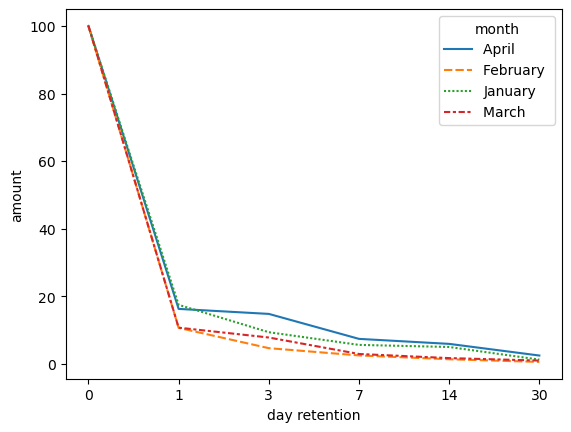

In [27]:
sns.lineplot(data=retention_long, x="day retention", y="amount", hue="month", style="month")
plt.show()

В нашем случае N Day Retention не очень показателен, ведь если человек пришел не в 7, а в
8 день - это же не значит, что платформа его потеряла.                      
Поэтому рассчитаем Rolling Retention

`Rolling Retention` - показывает, сколько людей воспользовались продуктом в день N и в любой день после него.

In [28]:
Rolling_Retention = '''
WITH prep as(
    SELECT u2.user_id, 
           TO_CHAR(u.date_joined, 'Month') as month, 
           MAX(DATE(u2.entry_at)-DATE(u.date_joined)) as diff
    FROM users u
    JOIN userentry u2 ON u.id = u2.user_id
    WHERE TO_CHAR(u.date_joined, 'YYYY') = '2022'
    GROUP BY u2.user_id, month),
prep2 as(
    SELECT month, user_id,
           MAX(CASE WHEN diff >= 0 THEN 1 END) as "0",
           MAX(CASE WHEN diff >= 1 THEN 1 END) as "1",
           MAX(CASE WHEN diff >= 3 THEN 1 END) as "3",
           MAX(CASE WHEN diff >= 7 THEN 1 END) as "7",
           MAX(CASE WHEN diff >= 14 THEN 1 END) as "14",
           MAX(CASE WHEN diff >= 30 THEN 1 END) as "30"
    FROM prep
    GROUP BY month, user_id),
prep3 as(
    SELECT month, 
           SUM("0") as "0",
           SUM("1") as "1",
           SUM("3") as "3",
           SUM("7") as "7",
           SUM("14") as "14",
           SUM("30") as "30"
    FROM prep2
    GROUP BY month)
SELECT * FROM prep3
'''
pd.io.sql.read_sql(Rolling_Retention, con = engine)

,month,0,1,3,7,14,30
0,April,208,99,76,61,46,22
1,February,891,292,212,147,115,85
2,January,498,222,184,151,126,77
3,March,415,144,109,77,60,35


Также переведём в проценты

In [29]:
Rolling_Retention_percent = '''
WITH prep as(
    SELECT u2.user_id, 
           TO_CHAR(u.date_joined, 'Month') as month, 
           MAX(DATE(u2.entry_at)-DATE(u.date_joined)) as diff
    FROM users u
    JOIN userentry u2 ON u.id = u2.user_id
    WHERE TO_CHAR(u.date_joined, 'YYYY') = '2022'
    GROUP BY u2.user_id, month),
prep2 as(
    SELECT month, user_id,
           MAX(CASE WHEN diff >= 0 THEN 1 END) as "0",
           MAX(CASE WHEN diff >= 1 THEN 1 END) as "1",
           MAX(CASE WHEN diff >= 3 THEN 1 END) as "3",
           MAX(CASE WHEN diff >= 7 THEN 1 END) as "7",
           MAX(CASE WHEN diff >= 14 THEN 1 END) as "14",
           MAX(CASE WHEN diff >= 30 THEN 1 END) as "30"
    FROM prep
    GROUP BY month, user_id),
prep3 as(
    SELECT month, 
           SUM("0") as "0",
           SUM("1") as "1",
           SUM("3") as "3",
           SUM("7") as "7",
           SUM("14") as "14",
           SUM("30") as "30"
    FROM prep2
    GROUP BY month)
SELECT month, 
       MAX("0")/MAX("0")*100.0 as "0",
       ROUND(MAX("1")/MAX("0")::numeric*100, 2) as "1",
       ROUND(MAX("3")/MAX("0")::numeric*100, 2) as "3",
       ROUND(MAX("7")/MAX("0")::numeric*100, 2) as "7",
       ROUND(MAX("14")/MAX("0")::numeric*100, 2) as "14",
       ROUND(MAX("30")/MAX("0")::numeric*100, 2) as "30"
FROM prep3
GROUP BY month
'''
roll_retention = pd.io.sql.read_sql(Rolling_Retention_percent, con = engine)
roll_retention

,month,0,1,3,7,14,30
0,April,100.0,47.60,36.54,29.33,22.12,10.58
1,February,100.0,32.77,23.79,16.50,12.91,9.54
2,January,100.0,44.58,36.95,30.32,25.30,15.46
3,March,100.0,34.70,26.27,18.55,14.46,8.43


И также перевернём табличку и построим график

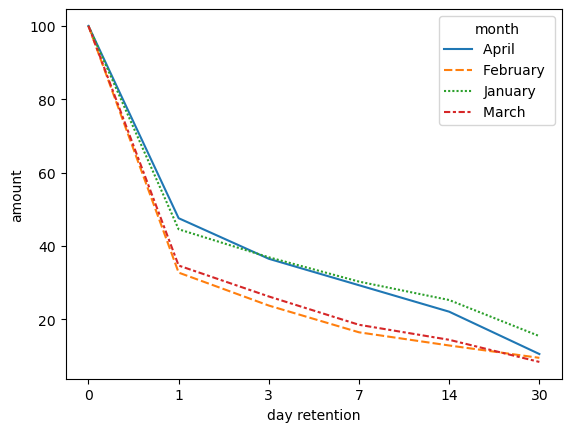

In [30]:
roll_retention_long = roll_retention.melt(id_vars= ['month'], var_name = 'day retention', value_name = 'amount')

sns.lineplot(data=roll_retention_long, x="day retention", y="amount", hue="month", style="month")
plt.show()

Для платформы IT Resume этот график будет являться более показательным графиком, а показатели очень даже неплохие.         
Почти 40% пользователей возвращаются на платформу после 2 недель использования

# Вывод:
<a id='part_4'></a>

* Трыгдыг

* Трыгдыг

* Трыгдыг

* Трыгдыг

* Трыгдыг
